<br>
<br>
<div class="alert alert-warning" style="text-align:right">
Gabriel Ángel Tamayo Leiva.<br> Enero 2020
</div>


<h1 style="font-family:'Comic Sans MS',cursive, sans-serif; color:orange"> Anime Recommendations Database </h1>

<h4 style="font-family:'Comic Sans MS',cursive, sans-serif; color:gray"> Recommendation data from 76,000 users at myanimelist.net </h4>

<br>
<br>


<p style="font-family:'Comic Sans MS', sans-serif; color:#545353;font-weight: bold;">
El objetivo del desafío es desarrollar un sistema de recomendación que permita sugerir anime que los
usuarios no han visto, en base a sus ratings previos.
</p>
<p style="font-family:'Comic Sans MS', sans-serif; color:#545353;font-weight: bold;">
Dataset: <br>
https://www.kaggle.com/CooperUnion/anime-recommendations-database#rating.csv y descargar los
archivos anime.csv y rating.csv.
Ambas tablas contienen información de las preferencias de 73.516 usuarios en 12.294 animes (series de
dibujos animados orientales). Cada usuario puede agregar un anime a su lista y darle un rating (de 0 a
10).
</p>    

<p style="font-family:'Comic Sans MS', sans-serif; color:#545353;font-weight: bold;">
descripción de la data:
    <br><br>
Anime.csv
<br>
• anime_id : id único del anime (de la página myanimelist.net)
<br>
• name : nombre del anime
<br>
• genre : lista de generos separados por coma del anime
<br>
• type : TV, movie (de película), OVA, etc...
<br>
• episodes : cantidad de episodios del show (1 si es película)
<br>
• rating : rating promedio (de 1-10) para este anime
<br>
• members : numero de miembros de la comunidad que están en el grupo del anime
<br><br>
Rating.csv
<br>
• user_id : id del usuario generado aleatoriamente
<br>
• anime_id : el anime que el usuario rankeo
<br>
• rating : el rating entre 1 y 10 que el usuario asignó al anime ( -1 si el usuario vio el anime pero no
le asignó puntaje)

</p>

In [1]:
# import libraries
import pandas as pd 
import numpy as np


import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from utils import *

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read csv anime and rating
df_anime = pd.read_csv("data/anime.csv")
df_rating = pd.read_csv("data/rating.csv")

<br>
<h2 style="font-family:'Comic Sans MS',cursive, sans-serif; color:orange"> Utils Functions </h2>
<p style="font-family:'Comic Sans MS', sans-serif; color:#545353;font-weight: bold;">
Se exponen para una revisión más rapida pero realmente se importan desde el archivo utils.py
</p>


```python

# Utils functions
import matplotlib.pyplot as plt
import seaborn as sns
import math


def missing_values(df, col_name):
    """
    input:
    df: dataframe
    col_name: column name in df
    Report missing values (nan) in df columns
    """
    count_null = df[df[col_name].isna()].shape[0]
    count_total = df[col_name].shape[0]
    print(f"\t{col_name}: {(count_null,count_total)} {count_null/count_total}%")
    

def basic_analisis_df(df, df_name):
    """
    input:
    df: dataframe
    df_name: title of report
    Report shape, datatype columns and missing values per df
    """
    print(df_name)
    print(f"(Filas,columnas): \n \t{df.shape}")
    print("columna (type):\n {}".format(''.join(["\t" + col +' ('+  str(df[col].dtype) + ')\n ' for col in df.columns])))
    print("Missing values (na_count , total) percent% \n")
    [missing_values(df,col) for col in df.columns]
    
def graph_df_basics(df, figsize=(15,15)):
    """
    df: dataframe
    figsize: tuple (widht, height) size figure (default (15,15))
    
    Plot each df column using sns.countplot in obect type and distplot in numeric type
    """
    height = math.ceil(df.shape[1]/2)
    ax = plt.figure(figsize=figsize)
    ax.subplots(height,2)
    image_pos = 1
    for col_name, col_serie in df.iteritems():
        plt.subplot(height,2,image_pos)
        plt.title(f"Chart {col_name}")
        if col_serie.dtype == 'object':
            valores_unicos = col_serie.unique().shape[0]
            if valores_unicos < 50:
                sns.countplot(col_serie,palette=sns.color_palette("Paired"));
            else:
                msje = f"Columna {col_name} es tipo object con {valores_unicos} categorias "
                plt.text(.2, .5, msje, fontsize=12)
        else:
            sns.distplot(col_serie.dropna(),color="red",
                 kde=False);
        image_pos +=1
        plt.tight_layout()
        
```

<br>
<h2 style="font-family:'Comic Sans MS',cursive, sans-serif; color:orange"> EDA anime.csv </h2>



In [3]:
# show head 5 rows
df_anime.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [4]:
basic_analisis_df(df_anime, "df_anime")

df_anime
(Filas,columnas): 
 	(12294, 7)
columna (type):
 	anime_id (int64)
 	name (object)
 	genre (object)
 	type (object)
 	episodes (object)
 	rating (float64)
 	members (int64)
 
Missing values (na_count , total) percent% 

	anime_id: (0, 12294) 0.0%
	name: (0, 12294) 0.0%
	genre: (62, 12294) 0.005043110460387181%
	type: (25, 12294) 0.0020335122824141857%
	episodes: (0, 12294) 0.0%
	rating: (230, 12294) 0.01870831299821051%
	members: (0, 12294) 0.0%


<br>
<p style="font-family:'Comic Sans MS', sans-serif; color:#545353;font-weight: bold;">

</p>
<br>


<p style="font-family:'Comic Sans MS', sans-serif; color:#545353;font-weight: bold;">
Dado el insignificante nivel de datos perdidos se opta por aplicar un dropna y eliminar todos aquellos registros que los contengan. Es importante destacar que esto implica eliminar del análisis algunos animes.
</p>

In [5]:
df_anime = df_anime.dropna()

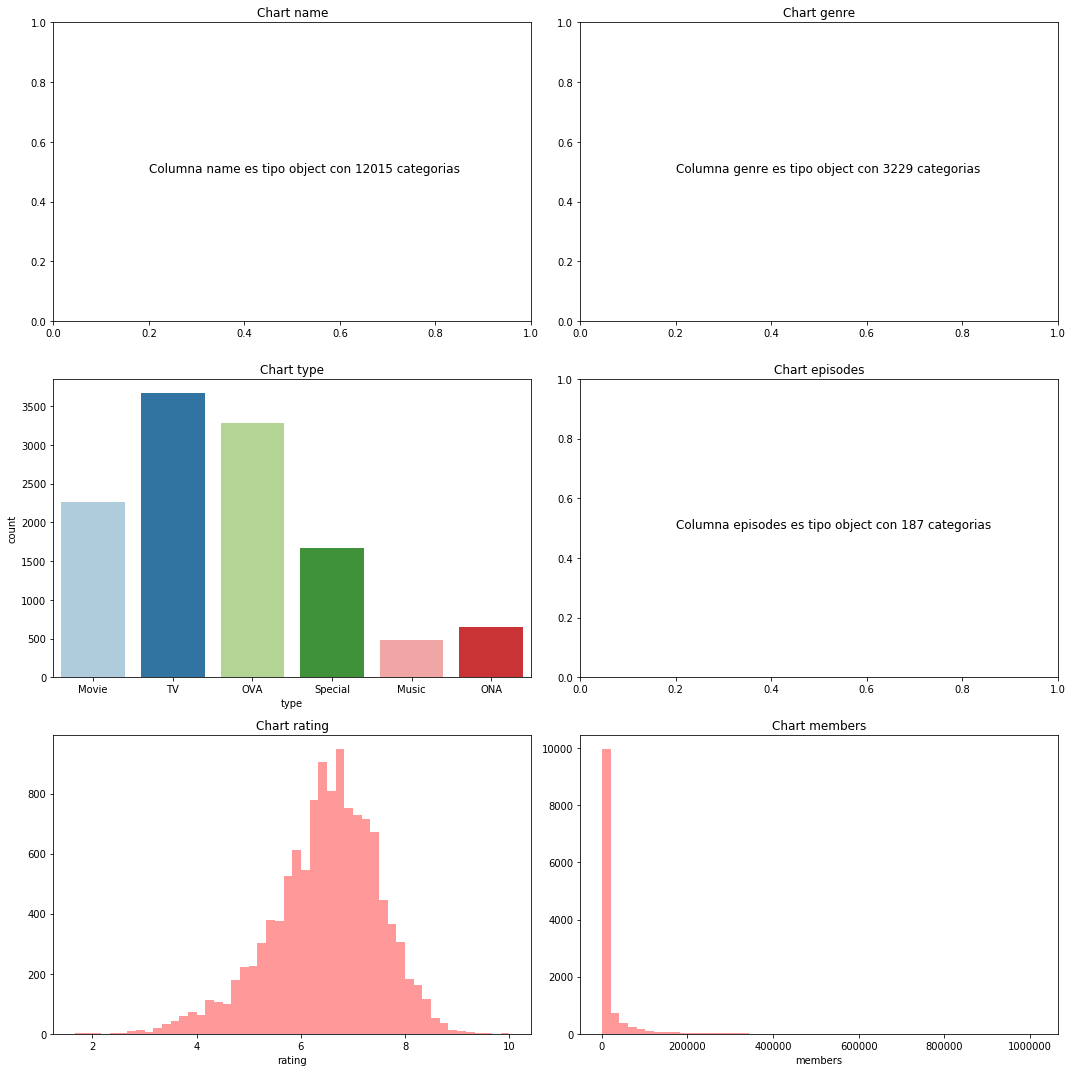

In [6]:
graph_df_basics(df_anime.drop(columns="anime_id"),(15,15))

In [7]:
df_anime[["rating","members"]].describe()

,rating,members
count,12017.000000,1.201700e+04
mean,6.478264,1.834888e+04
std,1.023857,5.537250e+04
min,1.670000,1.200000e+01
25%,5.890000,2.250000e+02
50%,6.570000,1.552000e+03
75%,7.180000,9.588000e+03
max,10.000000,1.013917e+06


<br>
<p style="font-family:'Comic Sans MS', sans-serif; color:#545353;font-weight: bold;">
    - Podemos ver que el rating tiene una distribución similar a una normal y sus rangos fluctuan entre el valor 1.67 y 10. <br>
    - La distribución de tipos de anime se analizá con más detalle posteriormente. <br>
    - La columna episodes no es posible gráficarla ya que es de tipo object por lo que tiene muchas categorías. Si en algun momento es necesario esa variable debe ser casteada <br>
</p>
<br>

<br>
<h4 style="font-family:'Comic Sans MS',cursive, sans-serif; color:orange">
¿Que tipo de anime es mejor evaluado? </h4>


In [8]:
df_anime.groupby(["type"]).mean().drop(columns="anime_id").sort_values("rating")

,rating,members
type,,
Music,5.588996,1311.840164
ONA,5.650293,4175.214506
Movie,6.334055,10564.510403
OVA,6.375411,6015.718027
Special,6.523126,7692.521557
TV,6.903321,43807.362050


<br>
<p style="font-family:'Comic Sans MS', sans-serif; color:#545353;font-weight: bold;">
    En promedio reciben mejor rating las TV series de anime y un peor rating el anime tipo Music. Las mismas pocisiones ocupan al comparar la cantidad de miembros promedio por tipo de anime.

</p>
<br>


<br>
<h4 style="font-family:'Comic Sans MS',cursive, sans-serif; color:orange">
¿Cúal es el tipo de anime predominante? </h4>


In [9]:
df_anime["type"].value_counts(True) * 100

TV         30.523425
OVA        27.327952
Movie      18.798369
Special    13.896979
ONA         5.392361
Music       4.060914
Name: type, dtype: float64

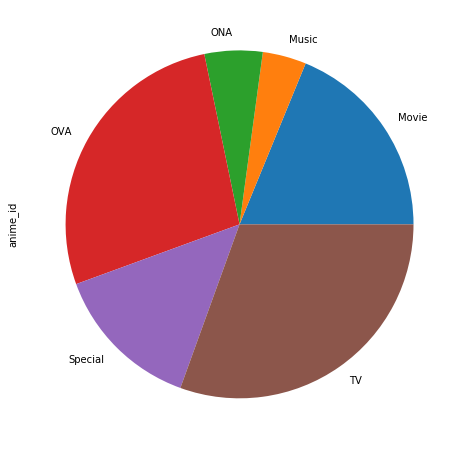

In [10]:
df_anime.groupby(["type"]).count()["anime_id"].plot(kind="pie",figsize=(8,8));

<br>
<p style="font-family:'Comic Sans MS', sans-serif; color:#545353;font-weight: bold;">
   Predominan las series de anime tipo TV , seguidos por OVA y en último lugar Music.
</p>
<br>

<br>
<h4 style="font-family:'Comic Sans MS',cursive, sans-serif; color:orange">
¿Cuales son las series mejor evaluadas? </h4>


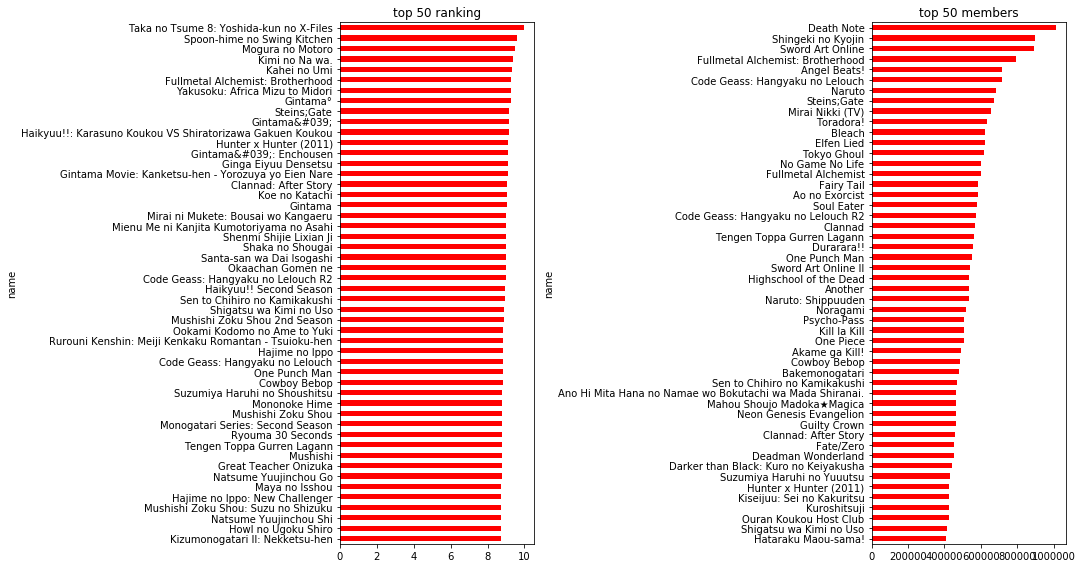

In [11]:
ax1,ax2 = plt.subplots(1,2)
ax1.set_size_inches((15,8))

df_anime.sort_values("members",ascending=True)[-50:].plot(kind="barh",x="name",
                                                          y=["members"],
                                                          ax=ax2[1],
                                                          title="top 50 members",
                                                          color="red",
                                                          legend=False)


df_anime.sort_values("rating",ascending=True)[-50:].plot(kind="barh",
                                                         x="name",
                                                         y=["rating"],
                                                         ax=ax2[0],
                                                         title="top 50 ranking",
                                                         color="red",
                                                          legend=False)
plt.tight_layout()


<br>
<h4 style="font-family:'Comic Sans MS',cursive, sans-serif; color:orange">
¿Existe alguna correlacion entre la evaluación de un anime y la cantidad de miembros? </h4>


In [12]:
df_anime[["rating","members"]].corr()

,rating,members
rating,1.000000,0.388499
members,0.388499,1.000000


<br>
<p style="font-family:'Comic Sans MS', sans-serif; color:#545353;font-weight: bold;">
    Existe un bajo nivel de correlacion positivo entre la evaluacion de un anime (ranking) y la cantidad de miembros.
</p>
<br>

<br>
<h2 style="font-family:'Comic Sans MS',cursive, sans-serif; color:orange"> EDA rating.csv </h2>


In [13]:
df_rating.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [14]:
basic_analisis_df(df_rating, "df_rating")

df_rating
(Filas,columnas): 
 	(7813737, 3)
columna (type):
 	user_id (int64)
 	anime_id (int64)
 	rating (int64)
 
Missing values (na_count , total) percent% 

	user_id: (0, 7813737) 0.0%
	anime_id: (0, 7813737) 0.0%
	rating: (0, 7813737) 0.0%


In [15]:
pd.Series(np.where(df_rating["rating"]==-1,"valor -1","otro_valor")).value_counts("%") * 100

otro_valor    81.103843
valor -1      18.896157
dtype: float64

<br>
<p style="font-family:'Comic Sans MS', sans-serif; color:#545353;font-weight: bold;">
   No existen valores perdidos y los tipos de datos son adecuados a los datos almacenados. Hay que considerar que en la columna  rating el valor -1 indica ausencia de evaluación que corresponde al 18.89% de los registros.
</p>
<br>

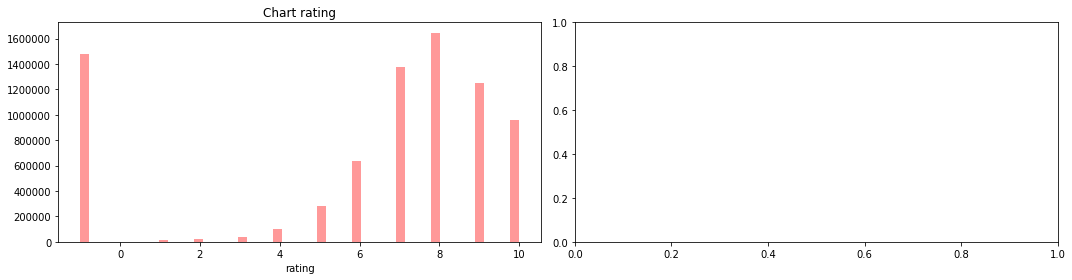

In [16]:
graph_df_basics(df_rating.drop(columns=["user_id","anime_id"]),(15,4))

In [17]:
df_rating["rating"].value_counts("%").sort_index() * 100

-1     18.896157
 1      0.213073
 2      0.296273
 3      0.530514
 4      1.334713
 5      3.619344
 6      8.162228
 7     17.600887
 8     21.065708
 9     16.049888
 10    12.231215
Name: rating, dtype: float64

In [18]:
# se elimina valor -1 en rating
df_rating.replace(-1,np.nan, inplace=True)

In [19]:
df_rating.describe()["rating"]

count    6.337241e+06
mean     7.808497e+00
std      1.572496e+00
min      1.000000e+00
25%      7.000000e+00
50%      8.000000e+00
75%      9.000000e+00
max      1.000000e+01
Name: rating, dtype: float64

In [20]:
basic_analisis_df(df_rating, "df_rating")

df_rating
(Filas,columnas): 
 	(7813737, 3)
columna (type):
 	user_id (int64)
 	anime_id (int64)
 	rating (float64)
 
Missing values (na_count , total) percent% 

	user_id: (0, 7813737) 0.0%
	anime_id: (0, 7813737) 0.0%
	rating: (1476496, 7813737) 0.18896156858107716%


<br>
<p style="font-family:'Comic Sans MS', sans-serif; color:#545353;font-weight: bold;">
   El porcentaje de valores nulos (18.9%) ahora coincide con la cantidad de -1 en la columna rating
</p>
<br>

<br>
<h2 style="font-family:'Comic Sans MS',cursive, sans-serif; color:orange"> Dataframe merged</h2>


In [21]:
# show shape of dfs
df_rating.shape, df_anime.shape

((7813737, 3), (12017, 7))

In [22]:
# merge dfs on anime_id
df_merged = pd.merge(df_rating, df_anime, how="left", on="anime_id",suffixes=("_user","" ))
df_merged.shape

(7813737, 9)

In [23]:
# drop nan values rows
df_merged.dropna(inplace=True)

In [24]:
# final df_merged shape
df_merged.shape

(6337146, 9)

In [25]:
# basic analisis final df_merged
basic_analisis_df(df_merged, "df_merged")

df_merged
(Filas,columnas): 
 	(6337146, 9)
columna (type):
 	user_id (int64)
 	anime_id (int64)
 	rating_user (float64)
 	name (object)
 	genre (object)
 	type (object)
 	episodes (object)
 	rating (float64)
 	members (float64)
 
Missing values (na_count , total) percent% 

	user_id: (0, 6337146) 0.0%
	anime_id: (0, 6337146) 0.0%
	rating_user: (0, 6337146) 0.0%
	name: (0, 6337146) 0.0%
	genre: (0, 6337146) 0.0%
	type: (0, 6337146) 0.0%
	episodes: (0, 6337146) 0.0%
	rating: (0, 6337146) 0.0%
	members: (0, 6337146) 0.0%


In [26]:
# selección de animes que tengan cantidad de rating superior a 80,
# esto se realiza para disminuir el tiempo de ejecución en el pivot del df
df_anime_selected = df_merged.groupby("anime_id").count()["rating_user"]
selected_animes_ids = df_anime_selected[df_anime_selected>80].index

<br>
<h2 style="font-family:'Comic Sans MS',cursive, sans-serif; color:orange"> Generate sparse matrix </h2>


In [27]:
# prepare pivot df matrix
matrix = df_merged[df_merged["anime_id"].isin(selected_animes_ids)].pivot_table(index='user_id', 
                                                                              columns='name', 
                                                                              values='rating')

In [28]:
# standarize data and replace nan values with 0
matrix = matrix.apply(lambda x: (x-np.mean(x))/(np.max(x)-np.min(x)), axis=1)
matrix.fillna(0, inplace=True)
matrix = matrix.T

# remove cols with 0s
matrix = matrix.loc[:,matrix.sum() != 0]
# generate sparse matrix
anime_mat_sparse = csr_matrix(matrix)
anime_mat_sparse

<4450x64918 sparse matrix of type '<class 'numpy.float64'>'
	with 6215951 stored elements in Compressed Sparse Row format>

<br>
<h2 style="font-family:'Comic Sans MS',cursive, sans-serif; color:orange"> KNN model </h2>


<br>
<p style="font-family:'Comic Sans MS', sans-serif; color:#545353;font-weight: bold;">
   Apelando al principio de parsimonia (y a la limitante de tiempo disponible) se utiliza el Modelo NearesNeighbors y como metrica de distancia la distancia del coseno.
</p>
<br>


In [29]:
anime_nnb = NearestNeighbors(metric='cosine').fit(anime_mat_sparse)
anime_nnb.kneighbors(anime_mat_sparse);

In [30]:
len(matrix.index)
df_anime.shape[0]

12017

In [31]:

def get_recomendation(matrix,model,recomendations=5,anime_name = "Pokemon"):
    # busca el index de anime_name
    anime_names = list(matrix.index)
    selected_anime_index = anime_names.index(anime_name)
    # encuentra los k vecinos de el anime buscado
    dist, ind = anime_nnb.kneighbors(matrix.iloc[selected_anime_index,:].values.reshape(1,-1),
                                     n_neighbors=recomendations)
    recomdended_indices, recomended_distances = ind.flatten(),dist.flatten()
    # show data de los animes recomendados
    for index, anime_index in enumerate(recomdended_indices):
        anime_name = anime_names[anime_index]
        anime_row = df_anime[df_anime["name"]== anime_name]
        if(index == 0): 
            print(f'Animes recomendados similares con {anime_name}:\n')
        else:
            print(f"distance: {recomended_distances[index]}")
            print(f'\t {anime_row["name"].values[0]}')
            print(f'\t type: {anime_row["type"].values[0]}')
            print(f'\t genero: {anime_row["genre"].values[0]}')
            print(f'\t episodios: {anime_row["episodes"].values[0]}')
            print("\n")   

<br>
<h2 style="font-family:'Comic Sans MS',cursive, sans-serif; color:orange"> Probando el Modelo </h2>


<img src="images/pokemon.jpg">

In [32]:
get_recomendation(matrix,anime_nnb,recomendations=5,anime_name = "Pokemon")

Animes recomendados similares con Pokemon:

distance: 0.6463763045747377
	 Pokemon Advanced Generation
	 type: TV
	 genero: Action, Adventure, Comedy, Fantasy, Kids
	 episodios: 192


distance: 0.7389031002562196
	 Pokemon: Maboroshi no Pokemon Lugia Bakutan
	 type: Movie
	 genero: Adventure, Comedy, Drama, Fantasy, Kids
	 episodios: 1


distance: 0.7479901167013556
	 Pokemon: Kesshoutou no Teiou Entei
	 type: Movie
	 genero: Action, Adventure, Comedy, Drama, Fantasy, Kids
	 episodios: 1


distance: 0.7520295975509534
	 Pokemon Diamond &amp; Pearl
	 type: TV
	 genero: Action, Adventure, Comedy, Fantasy, Kids
	 episodios: 191




<img src="images/Ranma_TV.jpg">


In [33]:
get_recomendation(matrix,anime_nnb,recomendations=5,anime_name = 'Ranma ½')

Animes recomendados similares con Ranma ½:

distance: 0.5704532727971023
	 Ranma ½ OVA
	 type: OVA
	 genero: Comedy, Martial Arts, Romance, Shounen
	 episodios: 6


distance: 0.6395992704842712
	 Ranma ½ Specials
	 type: OVA
	 genero: Comedy, Drama, Romance, Shounen
	 episodios: 2


distance: 0.6725770598488339
	 Ranma ½ Super
	 type: OVA
	 genero: Adventure, Comedy, Martial Arts, Romance, Shounen, Supernatural
	 episodios: 3


distance: 0.7643542390090962
	 Ranma ½: Akumu! Shunmin Kou
	 type: OVA
	 genero: Action, Comedy, Martial Arts, Shounen, Supernatural
	 episodios: 1




<img src="images/pucca.jpg">


In [34]:
get_recomendation(matrix,anime_nnb,recomendations=5,anime_name = "Pucca")

Animes recomendados similares con Pucca:

distance: 0.5433689800759326
	 Pucca (2006)
	 type: TV
	 genero: Comedy, Parody, Romance
	 episodios: 26


distance: 0.9168830564923357
	 Sonic X
	 type: TV
	 genero: Adventure, Comedy, Kids, Mecha, Sci-Fi, Shounen
	 episodios: 78


distance: 0.9412927950331111
	 Sekiranun Graffiti
	 type: Music
	 genero: Music
	 episodios: 1


distance: 0.9434738802122813
	 CLAMP in Wonderland
	 type: Music
	 genero: Music
	 episodios: 1




<img style="width:100%" src="images/neo.jpg">


In [35]:
get_recomendation(matrix,anime_nnb,recomendations=5,anime_name = "Neon Genesis Evangelion")

Animes recomendados similares con Neon Genesis Evangelion:

distance: 0.3092146261020534
	 Neon Genesis Evangelion: The End of Evangelion
	 type: Movie
	 genero: Dementia, Drama, Mecha, Psychological, Sci-Fi
	 episodios: 1


distance: 0.48582283301564366
	 Evangelion: 1.0 You Are (Not) Alone
	 type: Movie
	 genero: Action, Mecha, Sci-Fi
	 episodios: 1


distance: 0.530249022164097
	 Evangelion: 2.0 You Can (Not) Advance
	 type: Movie
	 genero: Action, Mecha, Sci-Fi
	 episodios: 1


distance: 0.5708823174859299
	 Cowboy Bebop
	 type: TV
	 genero: Action, Adventure, Comedy, Drama, Sci-Fi, Space
	 episodios: 26




<br>
<h2 style="font-family:'Comic Sans MS',cursive, sans-serif; color:orange"> Conclusiones y próximos pasos </h2>


<br>
<p style="font-family:'Comic Sans MS', sans-serif; color:#545353;font-weight: bold;">
   A pesar de la simplicidad del modelo, KNN es bastante robusto con la ventaja de funcionar con sparse matrix de numpy, lo que permite generar modelos "rapidamente" entrenables. Es de suma relevancia considerar que a pesar de que al probar el modelo con series especificas y obtener resultados que parecen tener sentido, se deben generar metricas de evaluación del modelo generado.
    <br> <br>
    Algunas mejoras del trabajo propuesto:
    <br> <br> 1° Al probar el modelo podemos ver que gran parte de las recomendaciones realizadas tienen sentido, sin embargo es de suma relevancia generar algun metodo de evaluacion que permita obtener metricas de desempeño del modelo generado. 
    <br> <br> 2° El modelo actual es capaz solo de recomendar aquellos animes que tienen más de 80 evaluaciones por velocidad de procesamiento (problema de facil correccion). 
   <br> <br> 3° Existen otras variables como el tipo de anime (movie, serie ,etc) y cantidad de episodios que potencialmente podrian ayudar considerablemente a generar mejores recomendaciones. Estos atributos actualmente no se estan utilizando dentro del sistema de recomendación.
  <br>  <br> 4° En base al 2° punto se recomienda utilizar algun enfoque diferente a un filtro colaborativo, como el uso de modelos más sofisticados (RBM Restricted Boltzmann machines), que nos permitan aprovechar de mejor forma la data disponible.
  <br>  <br> 5° Dado que se trata de datos de series de anime es altamente probable que se pueda enriquecer el dataset incorporando algun tipo de scrapper, esto nos permitiría por ejemplo extraer datos como director, escritor, año de lanzamiento de la serie, etc. Variables que podrian ser relevantes en la recomendación de un anime.
</p>
<br>
